# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy import optimize
import seaborn as sns
from theano.compile.ops import as_op
import theano.tensor as tt

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
results = pd.DataFrame()

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [4]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [5]:
exp_data = c14_patient_data.query('type == "non-hepatocyte"')
exp_data.describe()

,Dbirth,Dcoll,d14C,mass
count,8.000000,8.000000,8.000000,8.0
mean,1962.781250,2015.604167,0.061292,1.0
std,20.167992,4.357476,0.048558,0.0
min,1932.583333,2004.833333,0.015018,1.0
25%,1951.312500,2016.937500,0.020100,1.0
50%,1962.041667,2017.125000,0.051800,1.0
75%,1973.500000,2017.229167,0.083036,1.0
max,1995.333333,2017.416667,0.135400,1.0


# SSE & log-likelihood

In [6]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [7]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [8]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [9]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [10]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, exp_data),
                  Ns = 50,
                  full_output = True,
                  finish=None)

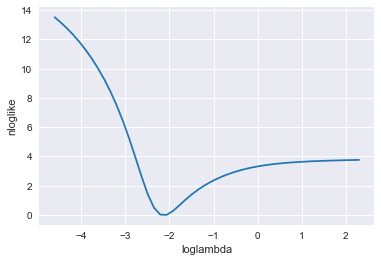

In [11]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

In [12]:
print(res[1])
res = sp.optimize.minimize(fun=Nloglike,
                           x0=res[0],
                           args=(I1, exp_data),
                           method='Nelder-Mead',
                           options={'maxfev': 600}
                          )

res = [res['x'], res['fun']]
res

-15.2301973154


[array([-2.1305245]), -15.264330636901281]

## Result

In [13]:
lam = sp.exp(res[0])
print('lamda', lam)

sig = Sigma([np.log(lam)], I1, exp_data)
print('sigma', sig)

results.loc['I1', 'loglike'] = -res[1]
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda [ 0.11877498]
sigma 0.0359013685582


,loglike,k,n,cAIC
I1,15.264331,2.0,8.0,-24.128661


# IK

In [14]:
@np.vectorize
def IK(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IK(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [15]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3.5, 0.5), (0.05, 0.999)],
                  args = (IK, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-2.02631579  0.89910526]
-15.2643135131


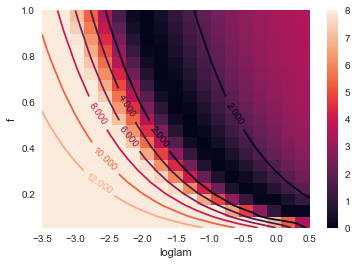

In [16]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [17]:
print(res[1])
res = sp.optimize.minimize(fun=Nloglike,
                           x0=res[0],
                           args=(IK, exp_data),
                           method='Nelder-Mead',
                           options={'maxfev': 600}
                          )

res = [res['x'], res['fun']]
res

-15.2643135131


[array([-2.02035452,  0.89477598]), -15.264334916904204]

## Result

In [18]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IK, exp_data)
print('sigma', sig)

results.loc['IK', 'loglike'] = -res[1]
results.loc['IK', 'k'] = 3
results.loc['IK', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.132608444569
f 0.894775981955
sigma 0.0359013493509


,loglike,k,n,cAIC
I1,15.264331,2.0,8.0,-24.128661
IK,15.264335,3.0,8.0,-18.528670


# IL

In [19]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [21]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3.0, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-0.10526316  0.11315789]
-15.2404185376


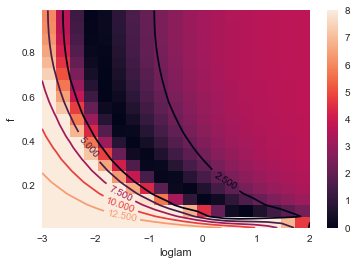

In [22]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [23]:
print(res[1])
res = sp.optimize.minimize(fun=Nloglike,
                           x0=res[0],
                           args=(IL, exp_data),
                           method='Nelder-Mead',
                           options={'maxfev': 600}
                          )

res = [res['x'], res['fun']]

-15.2404185376


## Result

In [24]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IL, exp_data)
print('sigma', sig)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 7.07517857991
f 0.0165021572309
sigma 0.0359017303072


,loglike,k,n,cAIC
I1,15.264331,2.0,8.0,-24.128661
IK,15.264335,3.0,8.0,-18.528670
IL,15.264250,3.0,8.0,-18.528500


# I2

In [25]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f, 
                         t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [26]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3, 0), (0.8, 1)],
                  args = (I2, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-2.05263158  1.        ]
-15.2132124355


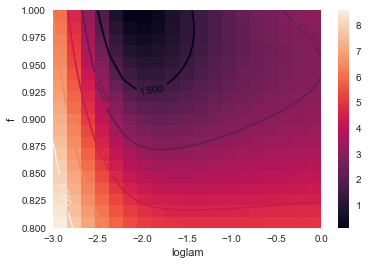

In [27]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [31]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, exp_data)
print('sigma', sig)

results.loc['I2', 'loglike'] = -res[1]
results.loc['I2', 'k'] = 3
results.loc['I2', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.128396572893
f 1.0
sigma 0.0361315047078


,loglike,k,n,cAIC
I1,15.264331,2.0,8.0,-24.128661
IK,15.264335,3.0,8.0,-18.528670
IL,15.264250,3.0,8.0,-18.528500
I2,15.213212,3.0,8.0,-18.426425


# Scenario IX2p

In [32]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2],
                        t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [33]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(2.0)),(np.log(0.01), np.log(2.0)) , (0, 1)],
                  args = (IX2p, exp_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-2.25036247  0.69314718  0.88888889]
-15.2895144241


In [34]:
print(res[1])
res = sp.optimize.minimize(fun=Nloglike,
                           x0=res[0],
                           args=(IX2p, exp_data),
                           method='Nelder-Mead',
                           options={'maxfev': 600}
                          )

res = [res['x'], res['fun']]
res

-15.2895144241


[array([-2.4770708,  0.8686423,  0.656483 ]), -15.335041653331199]

## Result

In [35]:
results.loc['IX2p', 'loglike'] = -res[1]
results.loc['IX2p', 'k'] = 4
results.loc['IX2p', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

,loglike,k,n,cAIC
I1,15.264331,2.0,8.0,-24.128661
IK,15.264335,3.0,8.0,-18.528670
IL,15.264250,3.0,8.0,-18.528500
I2,15.213212,3.0,8.0,-18.426425
IX2p,15.335042,4.0,8.0,-9.336750


# Results

In [36]:
results.sort_values('cAIC')

,loglike,k,n,cAIC
I1,15.264331,2.0,8.0,-24.128661
IK,15.264335,3.0,8.0,-18.528670
IL,15.264250,3.0,8.0,-18.528500
I2,15.213212,3.0,8.0,-18.426425
IX2p,15.335042,4.0,8.0,-9.336750
